In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reach_given_mean
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 5)

In [5]:
len(data_tr[2])

73531

In [6]:
print(np.mean(data_tr[2]))
data_tr = reach_given_mean(data_tr, np.mean(y_te_te))
print(np.mean(data_tr[2]))

0.21888727203492406
0.18681598731435206


In [7]:
type(data_vl)

list

In [8]:
len(data_tr[2])

70631

In [9]:
len(data_te_tr[2])

36735

In [10]:
print(np.mean(data_te_tr[2]))
data_te_tr = reach_given_mean(data_te_tr, np.mean(y_te_te))
print(np.mean(data_te_tr[2]))

0.2203348305430788
0.18679727427597956


In [11]:
len(data_te_tr[2])

35220

In [12]:
len(y_te_te)

1637

In [13]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.18681598731435206
0.191374246405936

0.18679727427597956
0.18243243243243243
0.18631643249847282


In [14]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2209/2208 | loss 0.7232 | val loss 0.7222 | acc 0.1912 | f1 0.3210 | prec 0.1912 | recall 0.9992 | roc auc 0.5402 | pr auc 0.2211 | elapsed 19.83s
train epoch 01/15 | batch 2209/2208 | loss 0.5417 | val loss 0.4491 | acc 0.8173 | f1 0.1231 | prec 0.7545 | recall 0.0670 | roc auc 0.6847 | pr auc 0.3631 | elapsed 74.03s
train epoch 02/15 | batch 2209/2208 | loss 0.3951 | val loss 0.4062 | acc 0.8334 | f1 0.3754 | prec 0.6639 | recall 0.2617 | roc auc 0.7853 | pr auc 0.5411 | elapsed 78.80s
train epoch 03/15 | batch 2209/2208 | loss 0.2910 | val loss 0.3683 | acc 0.8709 | f1 0.5689 | prec 0.7883 | recall 0.4451 | roc auc 0.8276 | pr auc 0.6698 | elapsed 80.18s
train epoch 04/15 | batch 2209/2208 | loss 0.2231 | val loss 0.3426 | acc 0.8807 | f1 0.6296 | prec 0.7754 | recall 0.5299 | roc auc 0.8511 | pr auc 0.7236 | elapsed 80.63s
train epoch 05/15 | batch 2209/2208 | loss 0.1833 |

In [15]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1102/1101 | loss 1.3920 | val loss 1.2863 | acc 0.6597 | f1 0.3899 | prec 0.2897 | recall 0.5960 | roc auc 0.6913 | pr auc 0.4428 | elapsed 9.95s
train epoch 01/10 | batch 1102/1101 | loss 1.1412 | val loss 0.9566 | acc 0.7181 | f1 0.4284 | prec 0.3399 | recall 0.5791 | roc auc 0.7263 | pr auc 0.5027 | elapsed 26.84s
train epoch 02/10 | batch 1102/1101 | loss 0.7160 | val loss 0.7339 | acc 0.7684 | f1 0.4800 | prec 0.4065 | recall 0.5859 | roc auc 0.7592 | pr auc 0.5579 | elapsed 26.61s
train epoch 03/10 | batch 1102/1101 | loss 0.4546 | val loss 0.5974 | acc 0.8127 | f1 0.5358 | prec 0.4889 | recall 0.5926 | roc auc 0.7865 | pr auc 0.6071 | elapsed 27.80s
train epoch 04/10 | batch 1102/1101 | loss 0.3089 | val loss 0.5147 | acc 0.8428 | f1 0.5789 | prec 0.5659 | recall 0.5926 | roc auc 0.8099 | pr auc 0.6468 | elapsed 28.17s
train epoch 05/10 | batch 1102/1101 | loss 0.2299 | val loss 0.4594 | acc 0.8575 | f1 0.6068 | prec 0.6109 | recall 0.6

In [16]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240723T202907


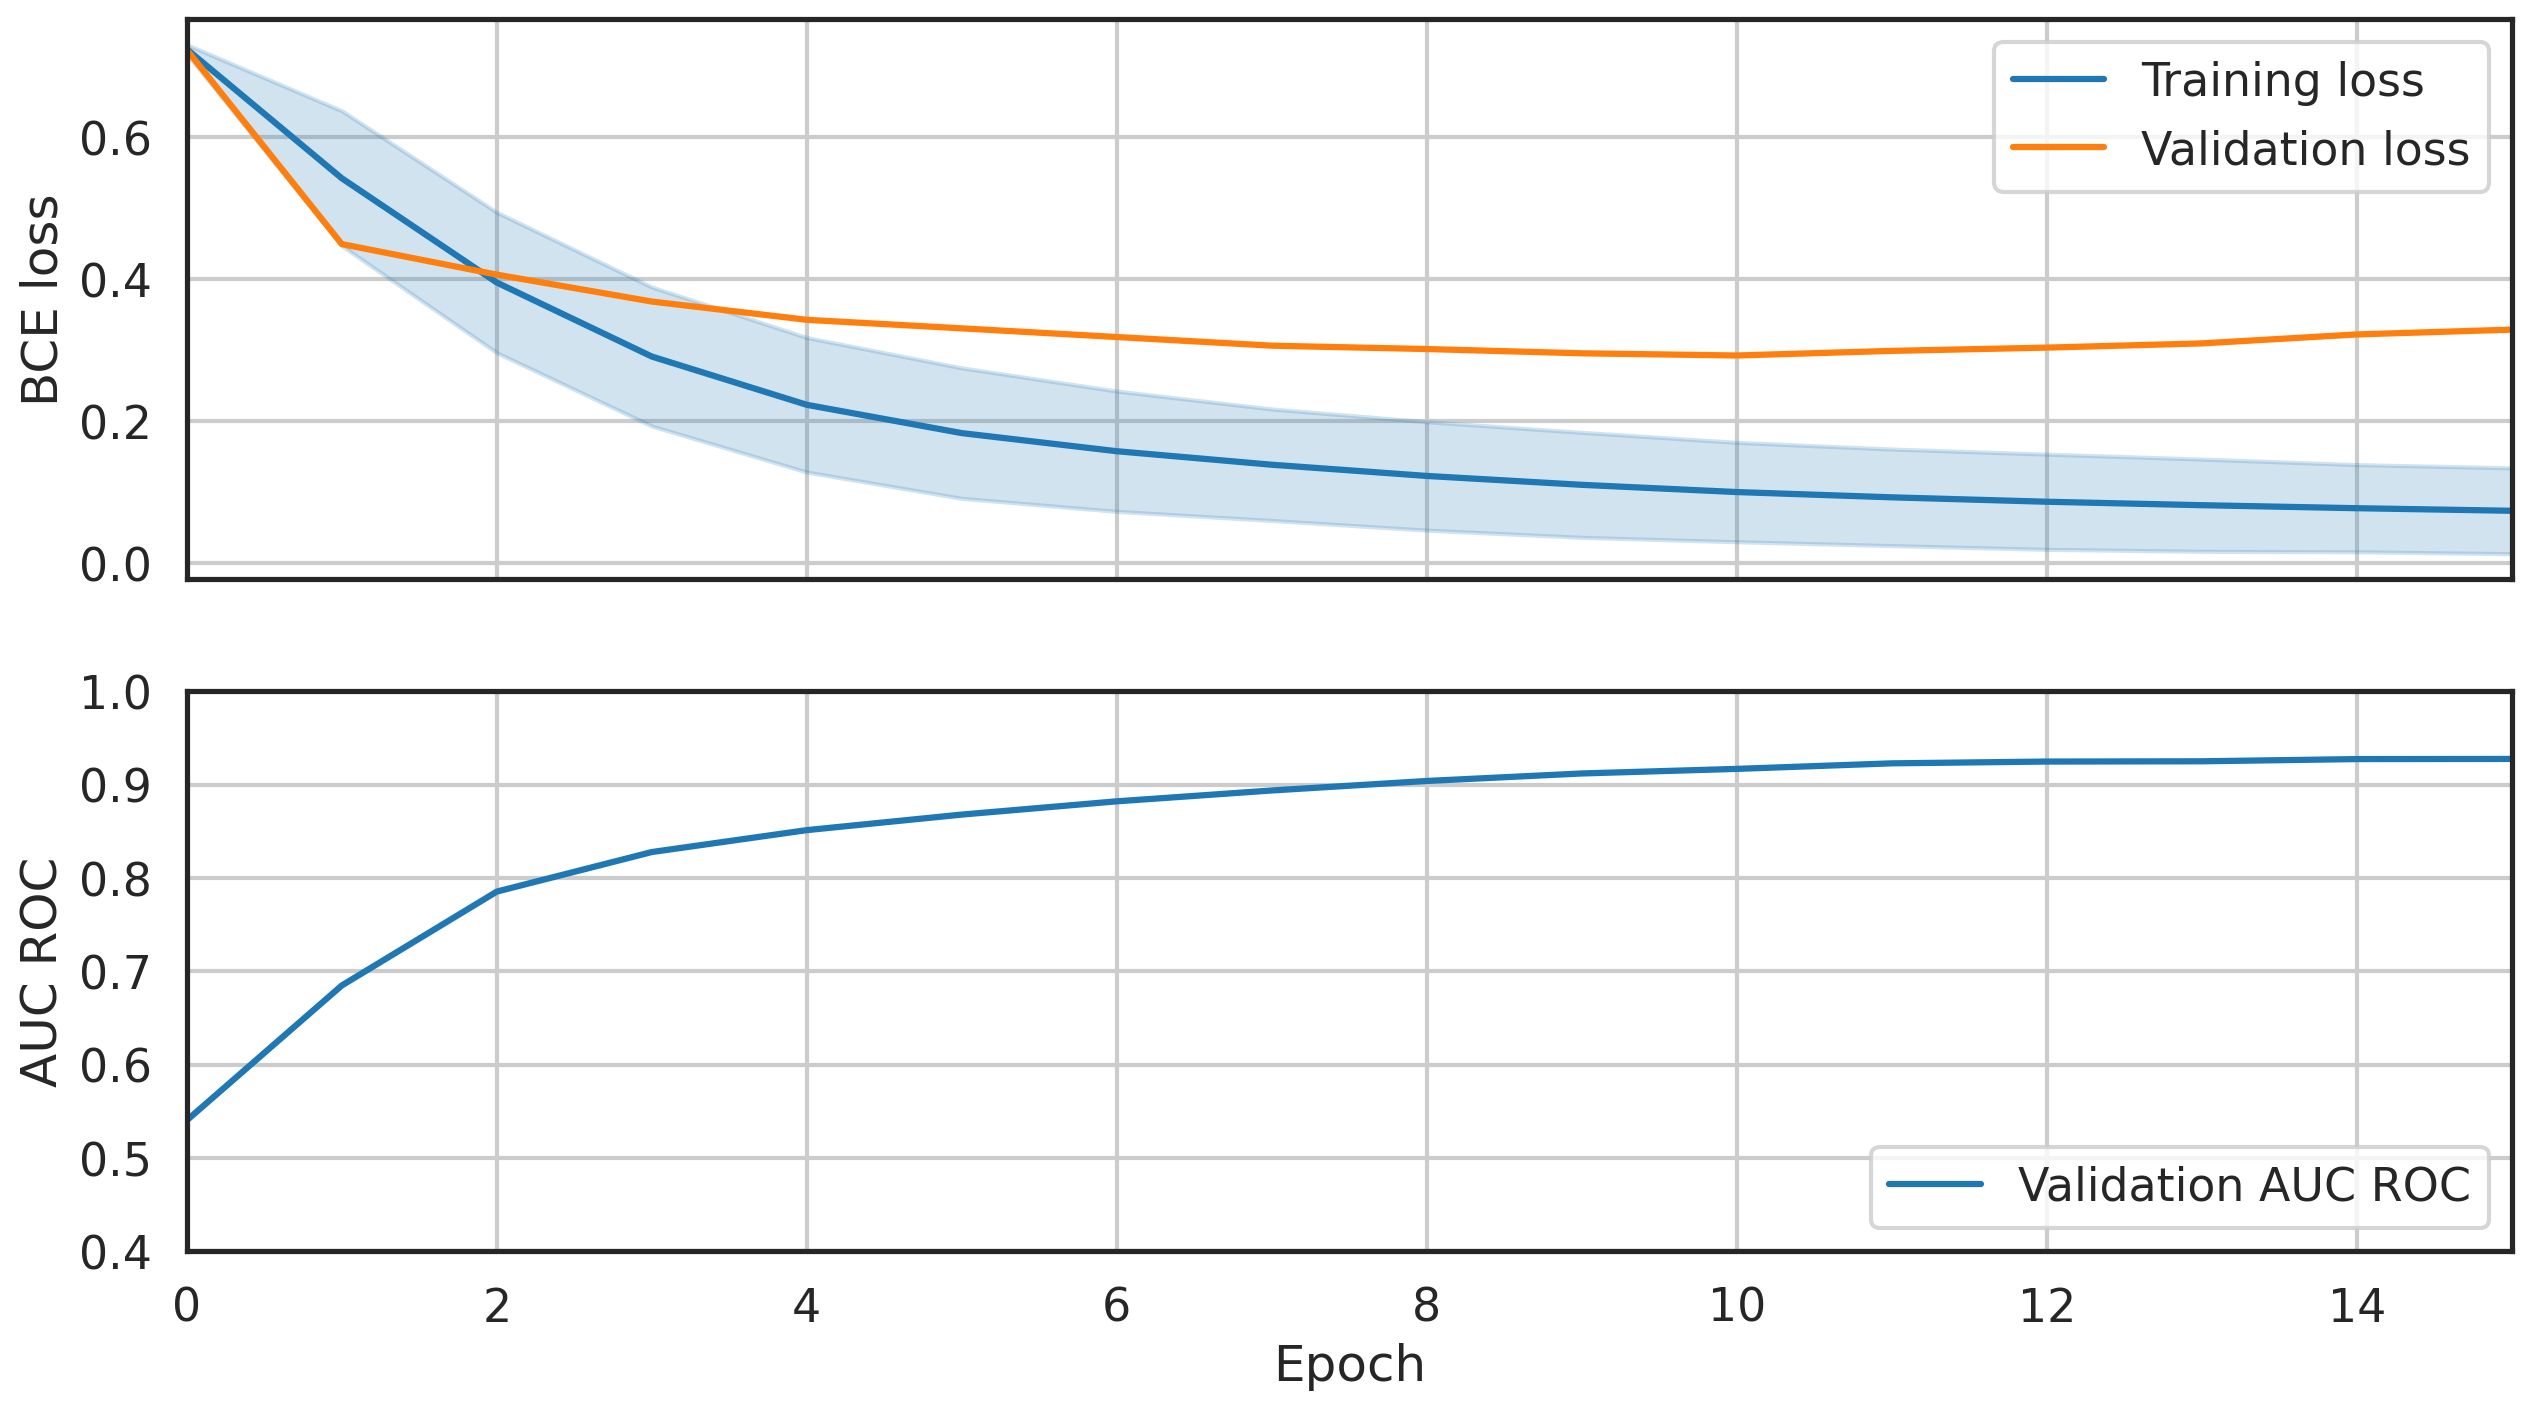

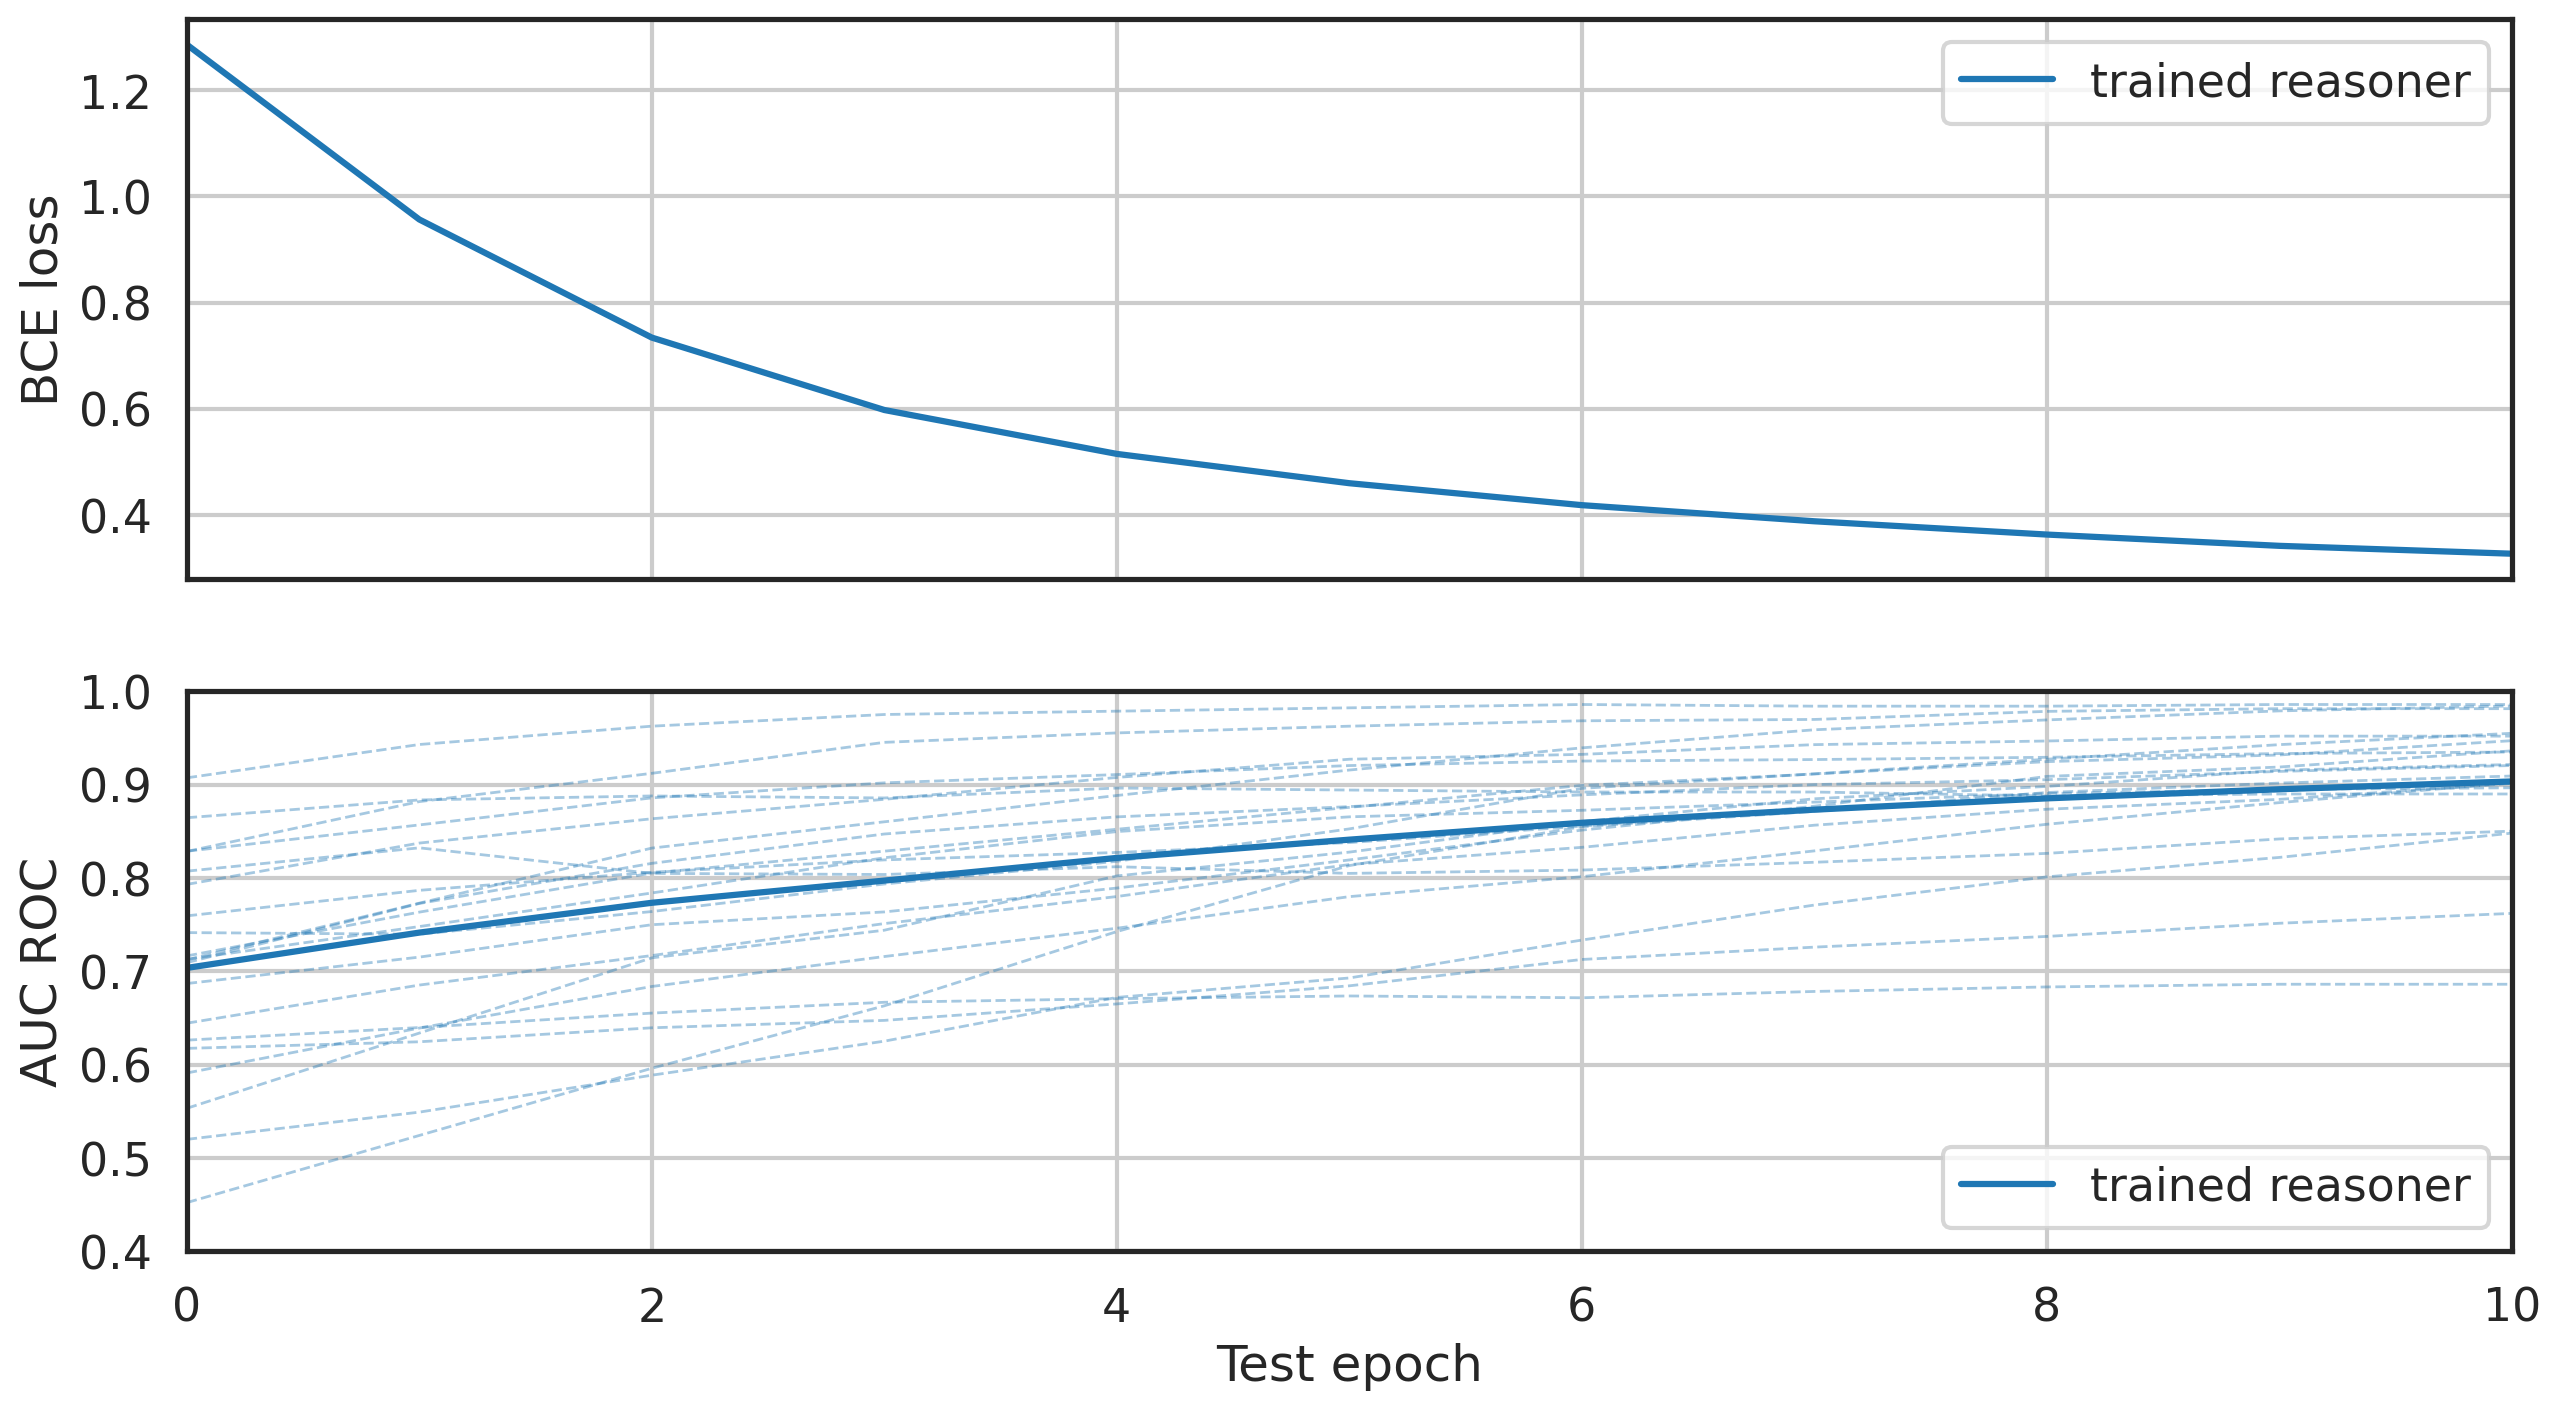

             mean       std     micro
acc      0.885887  0.046913  0.885767
prec     0.731708  0.193777  0.710714
recall   0.639618  0.221124  0.652459
f1       0.648122  0.183758  0.680342
auc_roc  0.883783  0.081261  0.880669
auc_pr   0.758249  0.150396  0.767169


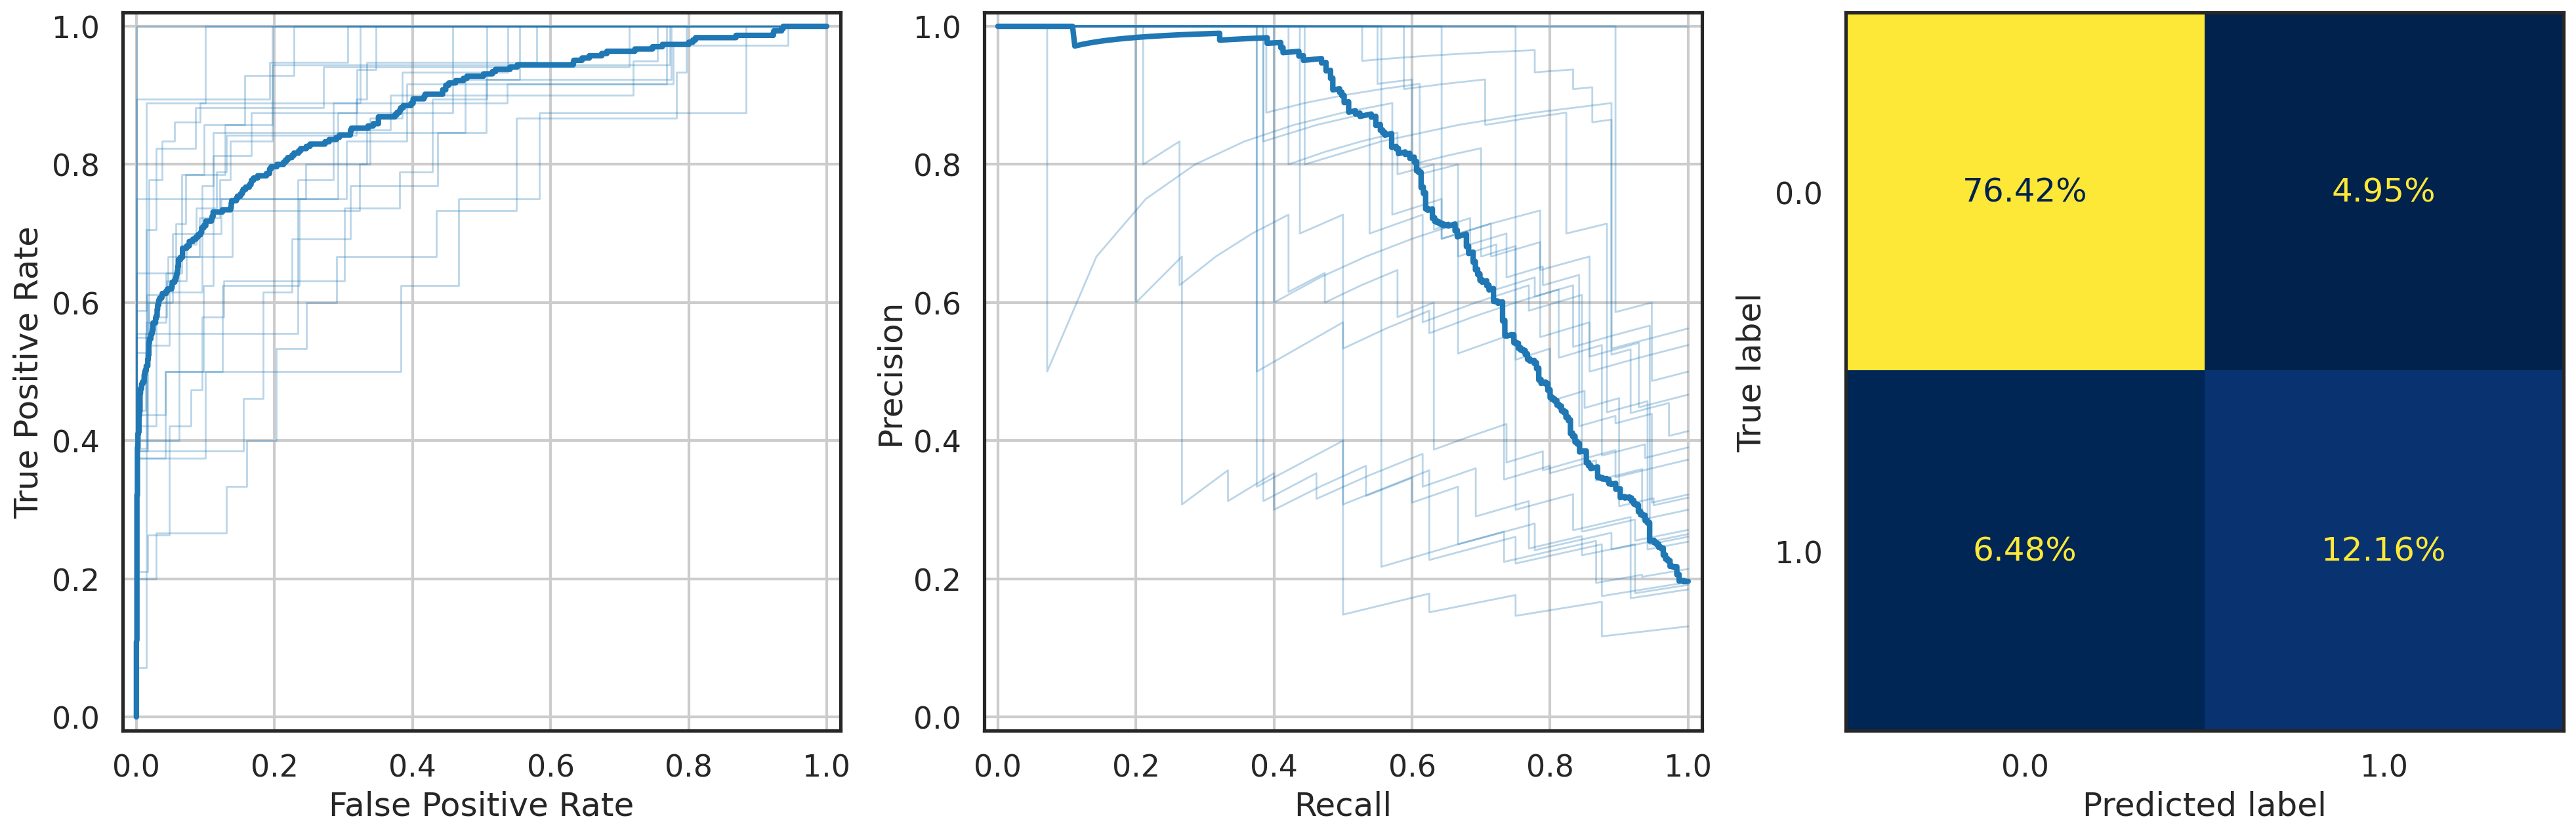

In [17]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [18]:
import random

In [30]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [31]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [32]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.268580
  Std Dev Loss: 0.031977
  Mean Diff: 0.550475
  Std Dev Diff: 0.095557

Duality of Top and Bottom:
  Mean Loss: 0.353681
  Std Dev Loss: 0.000000
  Mean Diff: 0.719191
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.127153
  Std Dev Loss: 0.031135
  Mean Diff: 0.313921
  Std Dev Diff: 0.088361

Associativity:
  Mean Loss: 0.037646
  Std Dev Loss: 0.013226
  Mean Diff: 0.084469
  Std Dev Diff: 0.028026

Commutativity:
  Mean Loss: 0.037846
  Std Dev Loss: 0.013633
  Mean Diff: 0.087869
  Std Dev Diff: 0.033051

Contradiction:
  Mean Loss: 0.362260
  Std Dev Loss: 0.020562
  Mean Diff: 0.833955
  Std Dev Diff: 0.084228

Identity with Top:
  Mean Loss: 0.151572
  Std Dev Loss: 0.037052
  Mean Diff: 0.365425
  Std Dev Diff: 0.111522

Absorption by Bottom:
  Mean Loss: 0.392830
  Std Dev Loss: 0.022338
  Mean Diff: 0.772328
  Std Dev Diff: 0.032560

Top Concept Subsumption:
  Mean Loss: 0.001258
  Std Dev Loss: 0.001332
  Mean Diff: N/A
  Std De